In [1]:
from train import train
from test import test, test_batch, class_accuracy
from plot import plot_training_batch
from model import MNIST_Net
from data import get_data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


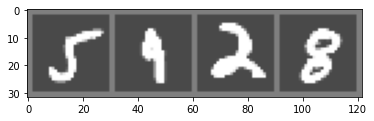

    5     4     2     8


In [2]:
data_set = 'MNIST'
trainloader, testloader, classes = get_data(data_set, batch_size=4)
plot_training_batch(data_set)

In [3]:
net = MNIST_Net()
try:
    net.load_model('mnist_net.pt')
except:
    train(net, trainloader)

model loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


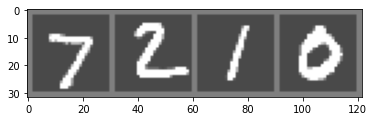

    7     2     1     0
Predicted:      7     2     1     0


In [4]:
test_batch(net, testloader, classes)


In [5]:
test(net, testloader)

Accuracy of the network on the 10000 test images: 97 %


In [6]:
class_accuracy(net, testloader, classes)

Accuracy for class 0     is: 98.7 %
Accuracy for class 1     is: 97.9 %
Accuracy for class 2     is: 97.5 %
Accuracy for class 3     is: 96.8 %
Accuracy for class 4     is: 95.6 %
Accuracy for class 5     is: 96.9 %
Accuracy for class 6     is: 97.6 %
Accuracy for class 7     is: 96.4 %
Accuracy for class 8     is: 98.8 %
Accuracy for class 9     is: 96.7 %


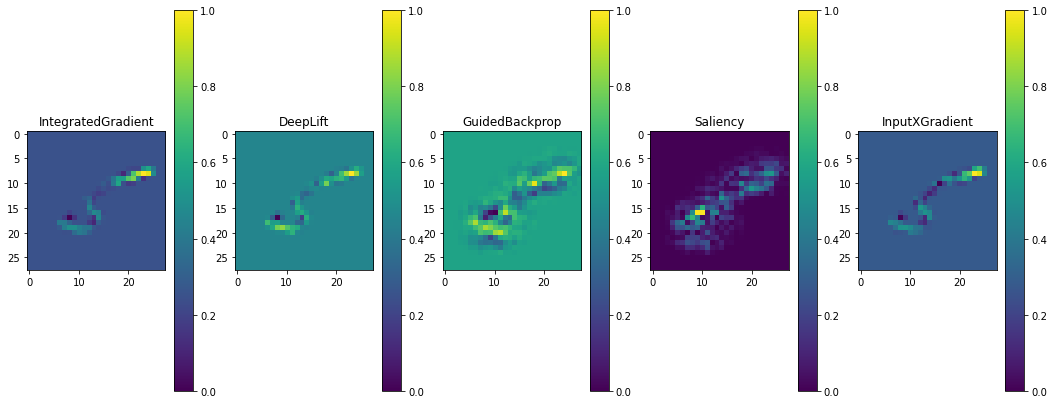

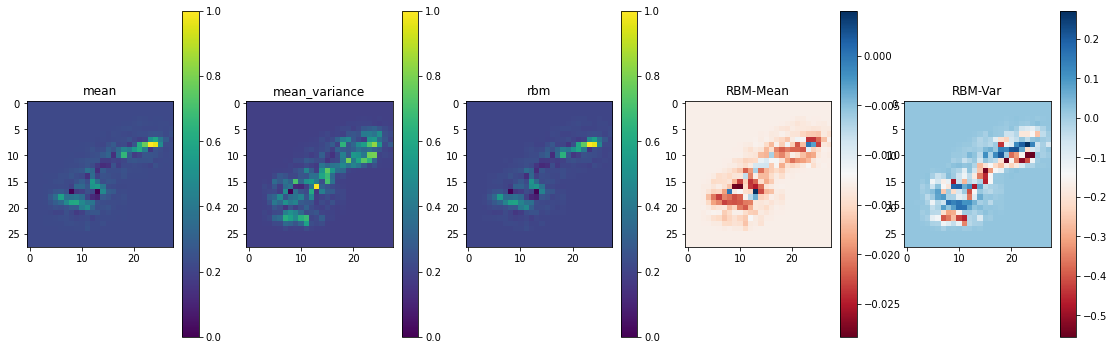

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import warnings
from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import Occlusion
from captum.attr import GuidedBackprop
from captum.attr import Lime
from captum.attr import KernelShap
from captum.attr import Saliency
from captum.attr import InputXGradient
warnings.filterwarnings('ignore')
from scipy.special import softmax

def calc_attribute(method, image, label): 
    if method == "IntegratedGradient": 
        ig = IntegratedGradients(net)
        attr = ig.attribute(image, target=label)
    elif method == "DeepLift": 
        dl = DeepLift(net)
        attr = dl.attribute(image, target=label)
    elif method == "Occlusion5": 
        oc = Occlusion(net)
        attr = oc.attribute(image, target=label, sliding_window_shapes=(1,5,5))
    elif method == "Occlusion8": 
        oc = Occlusion(net)
        attr = oc.attribute(image, target=label, sliding_window_shapes=(1,8,8))
    elif method == "GuidedBackprop": 
        gbp = GuidedBackprop(net)
        attr = gbp.attribute(image, target=label)
    elif method == "Lime": 
        lime = Lime(net)
        attr = lime.attribute(image, target=label, n_samples=200)
    elif method == "Saliency": 
        sv = Saliency(net)
        attr = sv.attribute(image, target=label)
    elif method == "InputXGradient":
        ixg = InputXGradient(net)
        attr = ixg.attribute(image, target=label)
    attr = attr.detach().numpy()
    return attr

def normalize(method, attributes):
    if method == "None":
         return attributes 
    elif method == "absolute":
         max = np.max(attributes, axis=(2,3))
         min = np.min(attributes, axis=(2,3))
         for i in range(attributes.shape[0]): 
             for j in range(attributes.shape[1]): 
                 attributes[i,j] = (attributes[i,j] - min[i,j]) / (max[i,j] - min[i,j])
         return attributes

def ensemble(method, attributes): 
    if method == "mean": 
        e = np.mean(attributes, axis=0)
    elif method == "mean_variance": 
        e = np.mean(attributes, axis=0) / (np.std(attributes, axis=0)+1e-6)
    elif method == "rbm":
        _, posterior_stoch = calculate_posterior(layers, attributes.copy().reshape(-1,28*28).T)
        e = posterior_stoch.reshape(28,28)
    return e


def explain_images(image_filter, methods, normalizer="absolute"): 
    images = trainloader.dataset.data[image_filter].clone()
    images = (images / 255)
    images = images.reshape(-1, 1, 28, 28)
    images.requires_grad = True
    labels = trainloader.dataset.targets[image_filter].clone()

    attributes = [calc_attribute(m, images, labels).reshape(-1, 28, 28) for m in methods]
    attributes = np.asarray(attributes, dtype=np.double)
    attributes = normalize(normalizer, attributes)
    return images, attributes

def plot_image_attribute(image, attributes, methods): 
    fig, axs = plt.subplots(1, len(attributes), figsize=(18,7))
    for i in range(len(attributes)): 
        im = axs[i].imshow(attributes[i])
        axs[i].set_title(methods[i])
        plt.colorbar(im, ax=axs[i])

    ensemble_methods = ["mean", "mean_variance", "rbm"]
    mean_ensemble = ensemble("mean", attributes)
    mean_ensemble = (mean_ensemble - np.min(mean_ensemble)) / (np.max(mean_ensemble)-np.min(mean_ensemble))
    #for j in range(10):
    #        mean_ensemble = (mean_ensemble - np.min(mean_ensemble)) / (np.max(mean_ensemble)-np.min(mean_ensemble))
    #        mean_ensemble = (mean_ensemble-np.mean(mean_ensemble)) / np.std(mean_ensemble)

    var_ensemble = ensemble("mean_variance", attributes)
    var_ensemble = (var_ensemble - np.min(var_ensemble)) / (np.max(var_ensemble)-np.min(var_ensemble))
    #for j in range(10):
    #        var_ensemble = (var_ensemble - np.min(var_ensemble)) / (np.max(var_ensemble)-np.min(var_ensemble))
    #        var_ensemble = (var_ensemble-np.mean(var_ensemble)) / np.std(var_ensemble)

    fig, axs = plt.subplots(1, len(ensemble_methods)+2, figsize=(19,6))
    for i in range(len(ensemble_methods)): 
        ens = ensemble(ensemble_methods[i], attributes)
        norm = (ens - np.min(ens)) / (np.max(ens)-np.min(ens))
        if ensemble_methods[i] == "rbm":
            div_from_mean = np.round(norm)==np.round(mean_ensemble)
            if np.mean(div_from_mean) < 0.5: 
                norm = 1-norm
            differences_mean = norm - mean_ensemble
            differences_var = norm - var_ensemble
        im = axs[i].imshow(norm)
        axs[i].set_title(ensemble_methods[i])
        plt.colorbar(im, ax=axs[i])
    
    im = axs[-2].imshow(differences_mean, cmap='RdBu', interpolation='none')
    axs[-2].set_title("RBM-Mean")
    plt.colorbar(im, ax=axs[-2])

    im = axs[-1].imshow(differences_var, cmap='RdBu', interpolation='none')
    axs[-1].set_title("RBM-Var")
    plt.colorbar(im, ax=axs[-1])

methods = ["IntegratedGradient", "DeepLift", "GuidedBackprop", "Saliency", "InputXGradient"]
recalculate = False

images, attributes = explain_images(np.arange(0,50), methods)
if recalculate: 
    batch_size_factor = 30
    probs = attributes.reshape(len(methods), -1)
    probs = np.repeat(probs, batch_size_factor, axis=0)
    probs = probs[np.random.permutation(probs.shape[0]),:]

    data = (probs > np.random.rand(probs.shape[0], probs.shape[1])).astype(int)
    data = data.reshape(10, -1, len(methods))

    layers = calculate_layers(data)
    posterior_det, posterior_stoch = calculate_posterior(layers, attributes[:,0].copy().reshape(-1,28*28).T)

image_id = 11
plot_image_attribute(images[image_id], attributes[:,image_id], methods)


(3, 80, 28, 28)

In [33]:
import math

def rbm(
    data, num_hidden, L2_regularization=True, 
    decay_lr_after_epochs = 120, lr_weight =5e-2, lr_bias_v = 5e-2,
    lr_bias_h = 5e-2, initial_momentum = 0.0, final_momentum = 0.9, 
    lmbda=1e-2, CD_iterations =10, max_epochs = 6, decay_momentum_after=90,
    i_increase_CD = 0):
    
    lr_weight0 = lr_weight
    lr_bias_v0 = lr_bias_v
    lr_bias_h0 = lr_bias_h

    num_batches, batch_size, dimensions = data.shape

    #Initialize weights and bias
    weight = 0.01 * np.random.rand(dimensions, num_hidden)
    bias_h = np.zeros(num_hidden)
    bias_v = np.zeros(dimensions)
    
    pos_probs_h = np.zeros((batch_size,num_hidden))
    neg_probs_h = np.zeros((batch_size,num_hidden))
    pos_prods = np.zeros((batch_size,num_hidden))
    neg_prods = np.zeros((batch_size,num_hidden))

    weight_incr = np.zeros((dimensions, num_hidden))
    bias_h_incr = np.zeros(num_hidden)
    bias_v_incr = np.zeros(dimensions)

    batch_pos_probs_h = np.zeros((batch_size, num_hidden, num_batches))

    for epoch in range(max_epochs): 

        if epoch > decay_lr_after_epochs: 
            lr_decr = 10**(-math.ceil(epoch - decay_lr_after_epochs)/10)
            lr_weight = lr_decr * lr_weight0
            lr_bias_v = lr_decr * lr_bias_v0
            lr_bias_h = lr_decr * lr_bias_h0

        err_sum = 0

        for batch_nr in range(num_batches): 
            bias_h_s = np.repeat([bias_h], batch_size, axis=0)
            bias_v_s = np.repeat([bias_v], batch_size, axis=0)

            #Positive phase
            batch_data = data[batch_nr, :,:]
            batch_data = (batch_data >= np.random.rand(batch_size, dimensions)).astype(int)

            pos_probs_h = 1.0 / (1.0 + np.exp(-batch_data@weight - bias_h_s)) #num_cases x num_dim @ num_dim x num_hidden => num_cases x num_hidden
            pos_prods = batch_data.T @ pos_probs_h #(num_cases x num_dim)^T @ num_cases x num_hiddden
            pos_act_h = np.sum(pos_probs_h) #question necessary? 
            pos_act_v = np.sum(batch_data) #question necessary?

            pos_probs_h_temp = pos_probs_h

            #Negative phase
            for i in range(CD_iterations): 
                pos_states_h = (pos_probs_h_temp >= np.random.rand(batch_size, num_hidden)).astype(int)
                neg_prob_v = 1.0 / (1 + np.exp(-pos_states_h@weight.T - bias_v_s)) #change
                neg_data = (neg_prob_v > np.random.rand(batch_size, dimensions)).astype(int)
                pos_probs_h_temp = 1.0 / (1.0 + np.exp(-neg_data @ weight - bias_h_s))
            neg_prob_h = pos_probs_h_temp

            neg_prods = neg_data.T @ neg_prob_h
            neg_act_h = np.sum(neg_probs_h)
            neg_act_v = np.sum(neg_data)

            err_sum += np.sum((batch_data-neg_data)**2)

            if epoch > decay_momentum_after:
                momentum = final_momentum
            else: 
                momentum = initial_momentum
            
            if L2_regularization: 
                weight_incr = (momentum * weight_incr 
                              + lr_weight * ((pos_prods-neg_prods)/batch_size - lmbda*weight))
                weight += weight_incr
            else: 
                weight_incr = (momentum * weight_incr 
                              + lr_weight * (pos_prods-neg_prods)/batch_size)
                v = weight + weight_incr
                t = lmbda*lr_weight
                m = abs(v)-t
                m[m<0] = 0
                weight += np.sign(v) * m
            
            bias_v_incr = momentum * bias_v_incr + lr_bias_v/batch_size*(pos_act_v-neg_act_v)
            bias_h_incr = momentum * bias_h_incr + lr_bias_h/batch_size*(pos_act_h-neg_act_h)
            
            bias_v += bias_v_incr
            bias_h += bias_h_incr
        
        print("    - Epoch {}, error: {:.2f}".format(epoch+1, err_sum))

    return weight, bias_v, bias_h, pos_states_h

def calculate_layers(training_data): 
    training_data_size = training_data.shape[0] * training_data.shape[1]
    batch_size = len(training_data)
    num_hidden = training_data.shape[2]

    layers = []

    while True: 
        #First calculation
        weight, bias_v, bias_h, _ = rbm(training_data, num_hidden)

        #SVD
        u, s, vh = np.linalg.svd(weight)
        s = np.sort(s)
        num_hidden = np.sum(np.cumsum(s) > np.sum(s)*0.25)

        #Retrain
        weight, bias_v, bias_h, pos_states_h = rbm(training_data, num_hidden, lmbda=0)
        layers.append([weight, bias_v, bias_h,])

        bias_h_s = np.repeat([bias_h], training_data_size, axis=0)
        hid_prob = 1.0 / (1 + np.exp(-training_data.reshape(training_data_size,-1)@weight-bias_h_s))
        training_data = np.round(hid_prob).reshape(batch_size, -1, num_hidden)
        
        print(f"Add layer of size {num_hidden}, s=",s)
        if num_hidden == 1: 
            break
    
    print(f"Trained a deep network with {len(layers)} layers.")
    return layers 

def calculate_posterior(layers, inference_data, nit = 100):
    original_inference_data = inference_data.copy()

    #Calculate posterior: Deterministic
    for weight, bias_v, bias_h in layers:
        bias_h_s = np.repeat([bias_h], inference_data.shape[0], axis=0)
        pos_prob_h = 1.0 / (1.0 + np.exp(-inference_data@weight-bias_h_s))
        inference_data = np.round(pos_prob_h)
    posterior_det = pos_prob_h

    #Calculate posterior: Stochastic
    probs = np.zeros((inference_data.shape[0], 1000))
    for i in range(nit): 
        inference_data = original_inference_data.copy()
        for weight, bias_v, bias_h in layers:
            pos_prob_h = 1.0 / (1.0 + np.exp(-inference_data@weight-bias_h_s))
            states_h = (pos_prob_h > np.random.rand(pos_prob_h.shape[0],pos_prob_h.shape[1])).astype(int)
            inference_data = states_h
        probs[:,i] = pos_prob_h.reshape(-1)
    posterior_stoch = np.mean(probs, axis=1)

    #Change: Add label flip
    #Change: Adjust that several are accepted

    return posterior_det, posterior_stoch

# batch_size_factor = 30
# probs = attributes.reshape(len(methods), -1)
# probs = np.repeat(probs, batch_size_factor, axis=0)
# probs = probs[np.random.permutation(probs.shape[0]),:]

# data = (probs > np.random.rand(probs.shape[0], probs.shape[1])).astype(int)
# data = data.reshape(10, -1, len(methods))

# layers = calculate_layers(data)
# posterior_det, posterior_stoch = calculate_posterior(layers, attributes[:,0].copy().reshape(-1,28*28).T)
# plt.imshow(posterior_stoch.reshape(28,28))
# plt.colorbar()